
# Определение перспективного тарифа для телеком компании

Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  
***Описание тарифов***  

***«Смарт»***
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 3 рубля
•	сообщение: 3 рубля
•	1 Гб интернет-трафика: 200 рублей  

***«Ультра»***
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 1 рубль
•	сообщение: 1 рубль
•	1 Гб интернет-трафика: 150 рублей  

**ПЛАН РАБОТЫ:**
1. [Открытие данных](#1)
2. [Подготовка данных](#2)
3. [Анализ данных](#3)
4. [Проверка гипотез](#4)
3. [Общий вывод](#5)


<a id="1"></a>
## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
#Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
import seaborn as sns


In [2]:
# прочитаем все файлы
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col='Unnamed: 0')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Файл "Клиенты"

Начнем с таблицы о пользователях. Известно, что у нас 500 пользователей. Ну посмотрим кто они, откуда и тд

In [3]:
# построим первые 5 строк
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
#уже из info видно, что пропуски только в столбце "churn_date"
# посмотрим еще раз информацию про пропуски
users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [6]:
#рассмотрим характеристики, дающие представление о выборке
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [7]:
#Посмотрим кол-во уникальных значений по тарифу
print(users['tariff'].value_counts(), '\n', (users['tariff'].value_counts()/500)*100)


smart    351
ultra    149
Name: tariff, dtype: int64 
 smart    70.2
ultra    29.8
Name: tariff, dtype: float64


In [8]:
# есть ли дубликаты
users.duplicated().sum()

0

#### Вывод:  
Что мы узнали о 500 пользователях:  
1. Возраст от 18 до 75 лет.  
2. 38 пользователей прекратили пользование тарифом.  
3. Из разных городов, преимущество за Москвой и СПб.  
4. Пользуются тарифами: SMART -70,2%, ULTRA -29,8%

Данные:  
1. Есть 462 пропуска в столбце "churn_date".  
2. Столбец "reg_date" имеет тип object. Необходимо заменить тип данных со строчного на datetime.

### Файл "Тарифы"

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
tariffs.duplicated().sum()

0

#### Вывод:

Всё соответствует описанию тарифов. Идеальная таблица с верным типом данных и без пропусков.

### Файл "Звонки"

In [12]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [13]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [14]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [15]:
calls.duplicated().sum()

0

Text(0, 0.5, 'user_id')

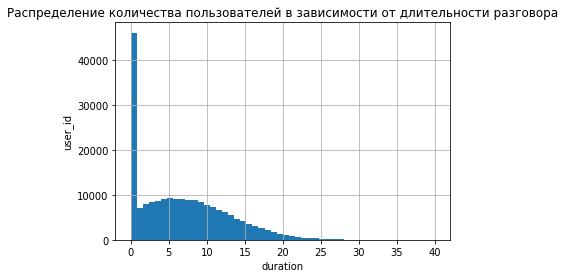

In [16]:
#построим график(гистограмму)
_=calls['duration'].hist(bins=50, range=(0, 40))
plt.title('Распределение количества пользователей в зависимости от длительности разговора')
plt.xlabel('duration')
plt.ylabel('user_id')

In [17]:
#посмотрим сколько значений=0
len(calls[calls.duration == 0])

39613

In [18]:
#сколько значений меньше 1
len(calls[calls.duration < 1])

47927

#### Вывод:  
1. Количество звонков - 202607  
2. Необходимо поменять типы данных столбцов:  
        call_date - на datetime
        duration - на int.  
3. Очень много звонков с длительностью 0 секунд. Это могут быть пропущенные звонки, как подсказано в описании проекта. 25% всей выборки имеют длительность в районе 1 секунды.  
    Тут можно предположить, что данные некорректны.

        

### Файл "Сообщения"

In [19]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [20]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [21]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [22]:
messages.duplicated().sum()

0

#### Вывод:  
Хороший файл: пропусков, дубликатов нет.  
Только нужно поменять тип данных в столбце 'message_date'.

### Файл "Интернет"

In [23]:
 internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [25]:

internet.duplicated().sum()

0

In [26]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Text(0, 0.5, 'user_id')

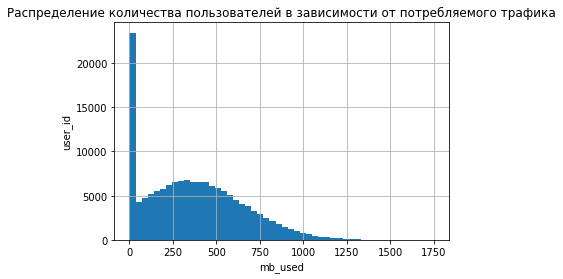

In [27]:
_=internet['mb_used'].hist(bins=50, range=(0, 1750))
plt.title('Распределение количества пользователей в зависимости от потребляемого трафика')
plt.xlabel('mb_used')
plt.ylabel('user_id')



In [28]:
len(internet[internet.mb_used == 0])

19598

#### Вывод:  
1. Необходимо поменять типы данных:  
        session_date - на datetime
        mb_used - на int.  
2. Очень много объёма потраченного за сессию интернет-трафика = 0 Мб. 
        

<a id="2"></a>  
## Шаг 2. Подготовьте данные

### Приведение данных к нужным типам

#### Изменение типа "временных" столбцов к типу ditetime

In [29]:
#создадим функцию для автоматизации приведения к нужному типу нужных временных столбцов из разных файлов
def convert_to_datetime(df, columns):
    for row in columns:
        df[row] = pd.to_datetime(df[row], format='%Y-%m-%d')

In [30]:
# Приводим временные столбцы к типу "datetime"
convert_to_datetime(users, ['reg_date', 'churn_date'])
convert_to_datetime(calls, ['call_date'])
convert_to_datetime(messages, ['message_date'])
convert_to_datetime(internet, ['session_date'])

In [31]:
#проверим какой-нибудь один файл
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


#### Изменение типа "float" столбцов к типу "int"

In [32]:
# создаем функцию для автоматизма
def astype_int(data, columns):
    for row in columns:
        data[row] = data[row].astype('int')

In [33]:
# меняем тип данных нужных столбцов
# astype_int(calls, ['duration'])
# astype_int(internet, ['mb_used'])

In [34]:
# проверяем один файл
# internet.info()

### Обнаружение ошибок и исправление данных

#### Длительность разговора

In [35]:
# Округляем длительность разговора вверх
import numpy as np
calls['duration'] = calls['duration'].apply(np.ceil)
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


Text(0, 0.5, 'user_id')

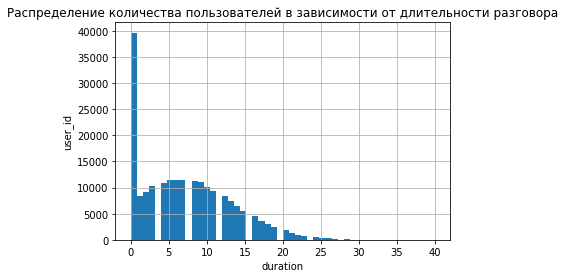

In [36]:
_=calls['duration'].hist(bins=50, range=(0, 40))
plt.title('Распределение количества пользователей в зависимости от длительности разговора')
plt.xlabel('duration')
plt.ylabel('user_id')

In [37]:
# Посмотрим сколько у нас нулей
len(calls[calls.duration == 0])

39613

А что делать с нулями? Нулевая их длительность вызвана прерыванием связи или случаями или как указано в описании проекта -могут быть пропущенные звонки. Т.к. они не расходуют лимиты минут и вообще не принимают участия в формировании конечной выручки, удаляем эти строки.

In [38]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

In [39]:
# Проверка
len(calls[calls.duration == 0])

0

Text(0, 0.5, 'user_id')

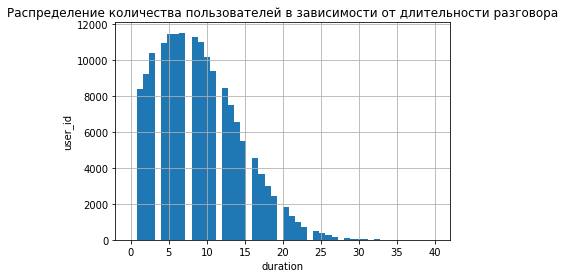

In [40]:
_=calls['duration'].hist(bins=50, range=(0, 40))
plt.title('Распределение количества пользователей в зависимости от длительности разговора')
plt.xlabel('duration')
plt.ylabel('user_id')

#### Потребление трафика

In [41]:
# Округляем трафик вверх
internet['mb_used'] = internet['mb_used'].apply(np.ceil)


In [42]:
#Проверка
len(internet[internet.mb_used == 0])

19598

Text(0, 0.5, 'user_id')

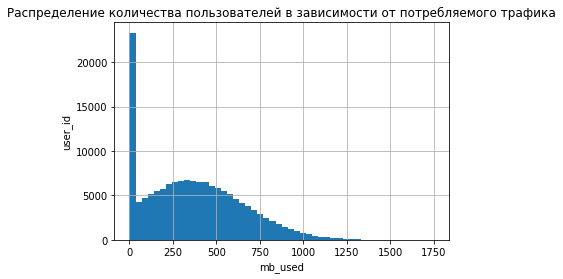

In [43]:
_=internet['mb_used'].hist(bins=50, range=(0, 1750))
plt.title('Распределение количества пользователей в зависимости от потребляемого трафика')
plt.xlabel('mb_used')
plt.ylabel('user_id')

In [44]:
# Посмотрим сколько у нас нулевого трафика
len(internet[internet.mb_used == 0])

19598

А что делать с нулевым трафиком?   
Такой случай может быть, что роутер включен,т.е. есть подключение к сети интернет, а потребления трафика нет. 

In [45]:
#удалим нулевой трафик
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

In [46]:
# Проверка
len(internet[internet.mb_used == 0])

0

Text(0, 0.5, 'user_id')

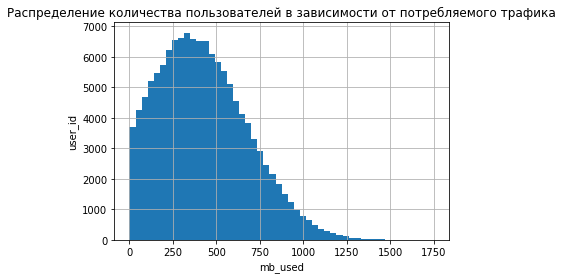

In [47]:
_=internet['mb_used'].hist(bins=50, range=(0, 1750))
plt.title('Распределение количества пользователей в зависимости от потребляемого трафика')
plt.xlabel('mb_used')
plt.ylabel('user_id')

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [48]:
# Создадим функцию для автоматизации добавления столбца 'month_year' в нужных файлах
def plus_month(data,columns):
    for row in columns:
        data['month_year'] = data[row].dt.to_period('M')
       

In [49]:
#Создадим функцию для автоматизации выводов сводной таблицы
def data_pivot_table(data, index, values, agg):
    return data.pivot_table(
            index=index,
            values=values,
            aggfunc=agg
        )     


In [50]:
# наша функция просто должна принять все необходимые аргументы и таблицу
def data_pivot_table(data, index, values, agg):
    return data.pivot_table(
            index=index,
            values=values,
            aggfunc=agg
        ) 

In [51]:
plus_month(calls, ['call_date'])

In [52]:
# Проверка
calls.columns

Index(['id', 'call_date', 'duration', 'user_id', 'month_year'], dtype='object')

In [53]:
# Выводим "автоматом" сводную таблицу по готовой функции 
calls_by_month=data_pivot_table(calls, ['month_year', 'user_id'], 'duration', ['count', 'sum'])
calls_by_month.reset_index()

,month_year,user_id,count,sum
,,,duration,duration
0,2018-01,1005,11,95.0
1,2018-01,1032,44,380.0
2,2018-01,1045,1,9.0
3,2018-01,1055,47,551.0
4,2018-01,1071,18,194.0
...,...,...,...,...
3163,2018-12,1494,54,418.0
3164,2018-12,1495,120,1031.0
3165,2018-12,1496,65,518.0


### Количество отправленных сообщений по месяцам

In [54]:
# добавим данные в готовую функцию для добавления столбца в файл
plus_month(messages, ['message_date'])

In [55]:
# Проверка
messages.columns

Index(['id', 'message_date', 'user_id', 'month_year'], dtype='object')

In [56]:
# Выводим "автоматом" сводную таблицу по готовой функции 
messages_by_month=data_pivot_table(messages, ['month_year', 'user_id'], 'id', 'count')
messages_by_month.reset_index()

,month_year,user_id,id
0,2018-01,1005,7
1,2018-01,1032,38
2,2018-01,1045,5
3,2018-01,1055,30
4,2018-01,1071,16
...,...,...,...
2712,2018-12,1493,78
2713,2018-12,1495,84
2714,2018-12,1496,51
2715,2018-12,1497,17


### Объем израсходованного интернет-трафика по месяцам

In [57]:
# добавим данные в готовую функцию для добавления столбца в файл
plus_month(internet, ['session_date'])

In [58]:
#проверка
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int64
month_year      129798 non-null period[M]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), period[M](1)
memory usage: 5.9+ MB


In [59]:
# Выводим "автоматом" сводную таблицу по готовой функции 
internet_by_month = data_pivot_table(internet, ['month_year', 'user_id'], 'mb_used', 'sum')
internet_by_month.reset_index()

,month_year,user_id,mb_used
0,2018-01,1005,2730.0
1,2018-01,1032,24147.0
2,2018-01,1045,2348.0
3,2018-01,1055,17111.0
4,2018-01,1071,15622.0
...,...,...,...
3196,2018-12,1494,17645.0
3197,2018-12,1495,23450.0
3198,2018-12,1496,20757.0
3199,2018-12,1497,19940.0


### Помесячная выручка с каждого пользователя

#### Соединение таблиц 

In [60]:
# Общую таблицу назовем
multi=pd.DataFrame()

In [61]:
#объединяем полученные таблицы в одну - data_services
multi = (
    calls_by_month.merge(messages_by_month, on=['user_id','month_year'], how='outer').
    merge(internet_by_month, on=['user_id','month_year'], how='outer').
    sort_values(by = ['user_id','month_year'])
)
multi =multi.reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [62]:
multi.head()

,user_id,month_year,"(count, duration)","(sum, duration)",id,mb_used
0,1000,2018-05,17.0,159.0,22.0,2256.0
1,1000,2018-06,28.0,172.0,60.0,23257.0
2,1000,2018-07,41.0,340.0,75.0,14016.0
3,1000,2018-08,42.0,408.0,81.0,14070.0
4,1000,2018-09,46.0,466.0,57.0,14581.0


In [63]:
multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id              3214 non-null int64
month_year           3214 non-null period[M]
(count, duration)    3168 non-null float64
(sum, duration)      3168 non-null float64
id                   2717 non-null float64
mb_used              3201 non-null float64
dtypes: float64(4), int64(1), period[M](1)
memory usage: 150.8 KB


In [64]:
multi = multi.drop_duplicates()

In [65]:
multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id              3214 non-null int64
month_year           3214 non-null period[M]
(count, duration)    3168 non-null float64
(sum, duration)      3168 non-null float64
id                   2717 non-null float64
mb_used              3201 non-null float64
dtypes: float64(4), int64(1), period[M](1)
memory usage: 175.8 KB


In [66]:
#заполняем пропуски (NaN) в data_services нулями (0)
multi= multi.fillna(0)

In [67]:
multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id              3214 non-null int64
month_year           3214 non-null period[M]
(count, duration)    3214 non-null float64
(sum, duration)      3214 non-null float64
id                   3214 non-null float64
mb_used              3214 non-null float64
dtypes: float64(4), int64(1), period[M](1)
memory usage: 175.8 KB


In [68]:
multi.head()

,user_id,month_year,"(count, duration)","(sum, duration)",id,mb_used
0,1000,2018-05,17.0,159.0,22.0,2256.0
1,1000,2018-06,28.0,172.0,60.0,23257.0
2,1000,2018-07,41.0,340.0,75.0,14016.0
3,1000,2018-08,42.0,408.0,81.0,14070.0
4,1000,2018-09,46.0,466.0,57.0,14581.0


In [69]:
multi.set_axis(['user_id', 'month_year','count_calls', 'minutes', 'messages', 'mb'], axis = 'columns', inplace = True) 
multi.head()

,user_id,month_year,count_calls,minutes,messages,mb
0,1000,2018-05,17.0,159.0,22.0,2256.0
1,1000,2018-06,28.0,172.0,60.0,23257.0
2,1000,2018-07,41.0,340.0,75.0,14016.0
3,1000,2018-08,42.0,408.0,81.0,14070.0
4,1000,2018-09,46.0,466.0,57.0,14581.0


In [70]:
multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id        3214 non-null int64
month_year     3214 non-null period[M]
count_calls    3214 non-null float64
minutes        3214 non-null float64
messages       3214 non-null float64
mb             3214 non-null float64
dtypes: float64(4), int64(1), period[M](1)
memory usage: 175.8 KB


In [71]:
multi[['count_calls','minutes','messages','mb']]=multi[['count_calls','minutes','messages','mb']].astype('int')
multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id        3214 non-null int64
month_year     3214 non-null period[M]
count_calls    3214 non-null int64
minutes        3214 non-null int64
messages       3214 non-null int64
mb             3214 non-null int64
dtypes: int64(5), period[M](1)
memory usage: 175.8 KB


Соединим еще таблицы "Клиенты" и "Тарифы"

In [72]:
#Сперва переименуем столбец в файле тарифов
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [73]:
# соединяем 3 таблицы
multi = multi.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')

In [74]:
multi.head()

,user_id,month_year,count_calls,minutes,messages,mb,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05,17,159,22,2256,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06,28,172,60,23257,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07,41,340,75,14016,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08,42,408,81,14070,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09,46,466,57,14581,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [75]:
multi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                  3214 non-null int64
month_year               3214 non-null period[M]
count_calls              3214 non-null int64
minutes                  3214 non-null int64
messages                 3214 non-null int64
mb                       3214 non-null int64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minut

In [76]:
#Функция расчета помесячной выручки с каждого пользователя
def money_serv(row):
    money_calls = (row['minutes'] - row['minutes_included'])*row['rub_per_minute']
    if money_calls < 0:
        money_calls = 0
    money_messages = (row['messages'] - row['messages_included'])*row['rub_per_message']
    if money_messages < 0:
        money_messages = 0
    money_internet = ((row['mb'] - row['mb_per_month_included'])/1024)*row['rub_per_gb']
    if money_internet < 0:
        money_internet = 0
    money_total =  money_calls + money_messages + money_internet + row['rub_monthly_fee']
    return money_total

In [77]:
#считаем помесячную выручку с каждого пользователя

multi['total_money'] = multi.apply(money_serv, axis=1)

In [78]:
multi[['user_id', 'month_year', 'total_money']]

,user_id,month_year,total_money
0,1000,2018-05,1950.000000
1,1000,2018-06,1950.000000
2,1000,2018-07,1950.000000
3,1000,2018-08,1950.000000
4,1000,2018-09,1950.000000
...,...,...,...
3209,1498,2018-10,1574.218750
3210,1499,2018-09,550.000000
3211,1499,2018-10,1028.320312
3212,1499,2018-11,1425.500000


Text(0, 0.5, 'user_id')

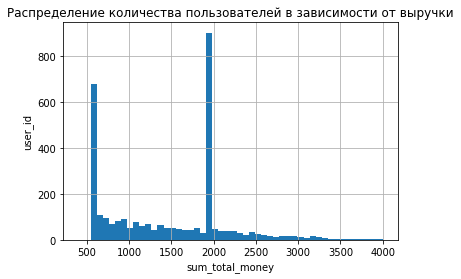

In [79]:
multi['total_money'].hist(bins=50, range=(400,4000))
plt.title('Распределение количества пользователей в зависимости от выручки')
plt.xlabel('sum_total_money')
plt.ylabel('user_id')

In [80]:
#посмотрим для себя суммарную выручку по тарифам
money_of_tarif = multi.pivot_table(
    index=['tariff'],
    values='total_money',
    aggfunc=['sum']
)
money_of_tarif.head()

,sum
,total_money
tariff,
smart,2.749136e+06
ultra,2.029622e+06


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c64cb3390>],
      dtype=object)

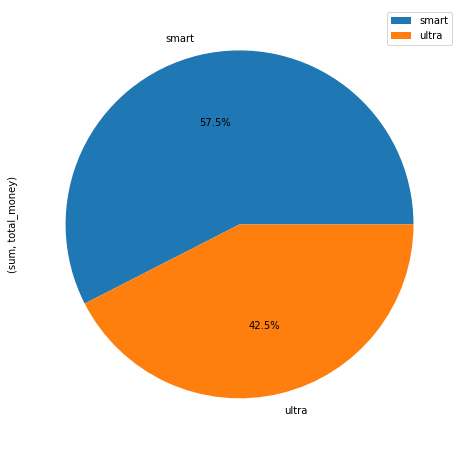

In [81]:
money_of_tarif.plot(subplots=True, kind='pie', autopct='%1.1f%%', figsize=(8, 8)) 

#### Вывод:  
Из графика видно, 2 больших максимума: это и есть наши абонентские платы 550 и 1950 руб. Достаточно большое распределение есть и в интервале от 550 и 1950, и уже меньше от 1950. Можем предположить, что это выручка от доп.услуг пользователей, то есть перерасход услуг, включенных в тарифы.  
Из сводной таблицы видно, что тариф Smart приносит почти в 1.5 раза больше выручки.



<a id="3"></a>  
## Шаг 3. Анализ данных

### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [82]:
#длительность звонков по тарифам и по месяцам
multi.pivot_table(index = 'month_year', values = 'minutes', columns = 'tariff', )

tariff,smart,ultra
month_year,,
2018-01,203.852941,428.111111
2018-02,298.689655,297.125000
2018-03,390.051948,489.648649
2018-04,367.133929,458.018182
2018-05,387.361702,510.328358
2018-06,395.640244,479.702381
2018-07,408.353234,545.791209
2018-08,421.468085,510.775701
2018-09,428.611538,539.443478


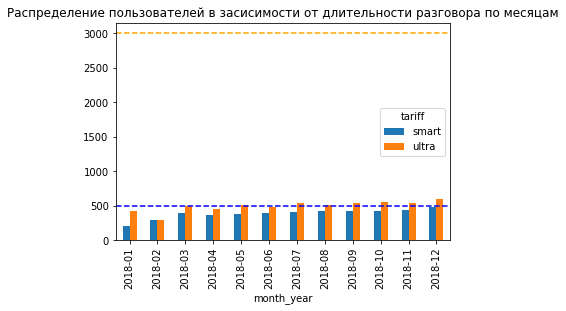

In [83]:
#строим график длительности звонков по тарифам и по месяцам
multi.pivot_table(index = 'month_year', values = 'minutes',columns = 'tariff').plot(kind = 'bar', title = 'Распределение пользователей в засисимости от длительности разговора по месяцам')
plt.axhline(3000, color = 'orange', linestyle = '--')
plt.axhline(500, color = 'blue', linestyle = '--')

In [84]:
#количество отправленных сообщений по тарифам и по месяцам
multi.pivot_table(index = 'month_year', columns = 'tariff', values = 'messages')


tariff,smart,ultra
month_year,,
2018-01,18.235294,33.777778
2018-02,24.086207,21.958333
2018-03,31.857143,32.297297
2018-04,30.741071,31.563636
2018-05,33.773050,37.850746
2018-06,33.402439,41.726190
2018-07,33.751244,49.846154
2018-08,33.638298,48.439252
2018-09,33.638462,52.286957


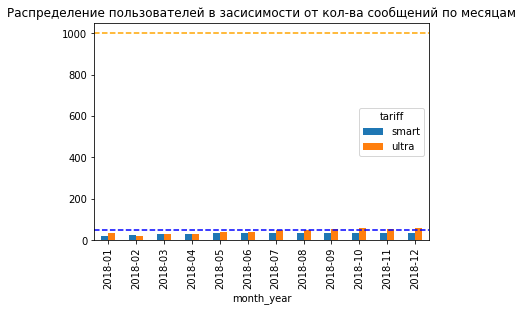

In [85]:
#строим график длительности звонков по тарифам и по месяцам
multi.pivot_table(index = 'month_year', columns = 'tariff', values = 'messages').plot(kind = 'bar', title = 'Распределение пользователей в засисимости от кол-ва сообщений по месяцам')
plt.axhline(1000, color = 'orange', linestyle = '--')
plt.axhline(50, color = 'blue', linestyle = '--')

In [86]:
#использованный трафик по тарифам и по месяцам
multi.pivot_table(index = 'month_year', columns = 'tariff', values = 'mb')

tariff,smart,ultra
month_year,,
2018-01,8524.441176,13153.555556
2018-02,11611.396552,11786.958333
2018-03,15123.857143,17551.972973
2018-04,13479.482143,16843.800000
2018-05,15825.198582,19381.194030
2018-06,15814.768293,18942.238095
2018-07,15763.512438,20514.648352
2018-08,16632.174468,19594.065421
2018-09,16324.526923,19222.208696


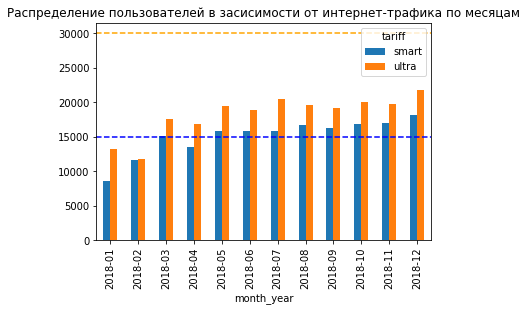

In [87]:
multi.pivot_table(index = 'month_year', columns = 'tariff', values = 'mb').plot(kind = 'bar', title = 'Распределение пользователей в засисимости от интернет-трафика по месяцам')
plt.axhline(30000, color = 'orange', linestyle = '--')
plt.axhline(15000, color = 'blue', linestyle = '--')

####  Вывод:  
***Телефония:***  
    Пользователи тарифа "Смарт" используют минуты почти полностью, а иногда даже и перерасходуют бесплатный трафик.  
    Пользователи тарифа "Ультра" пользуются минутами экономно и вписываются в свой лимит и даже остается большой запас.  
***Сообщения:***  
    Пользователи обоих тарифов не активно пользуются отправкой сообщений.  
    
***Трафик:***  
    Пользователи тарифа "Смарт" чаще всего выходят за рамки бесплатного трафика.  
    Пользователи тарифа "Ультра" укладываются в рамки бесплатного трафика.
    
Активность пользования услугами плавно растет из месяца в месяц, а так же ежемесячно растет и кол-во подключившихся абонентов. 
    

### Cреднее количество, дисперсия и стандартное отклонение

In [88]:
multi.pivot_table(index = 'tariff', values = ['minutes', 'messages', 'mb'], aggfunc = ['mean', 'var','std'])

mean                                  var               \
                  mb   messages     minutes            mb     messages   
tariff                                                                   
smart   16229.188425  33.384029  417.934948  3.454591e+07   796.812958   
ultra   19486.901523  49.363452  526.623350  1.019356e+08  2285.266143   

                                std                         
              minutes            mb   messages     minutes  
tariff                                                      
smart    36219.315784   5877.576978  28.227876  190.313730  
ultra   100873.633397  10096.317202  47.804457  317.606098

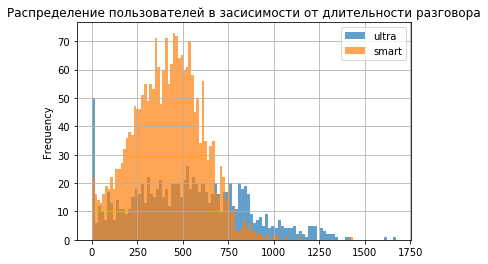

In [89]:
#построим гисторгаммы для 2 тарифов - телефония

ax=multi[multi['tariff'] == 'ultra'].plot(kind='hist', y='minutes', bins=100, alpha=0.7, label='ultra')
multi[multi['tariff'] == 'smart'].plot(kind='hist', y='minutes', bins=100, alpha=0.7, label='smart', ax=ax, grid=True, title='Распределение пользователей в засисимости от длительности разговора')

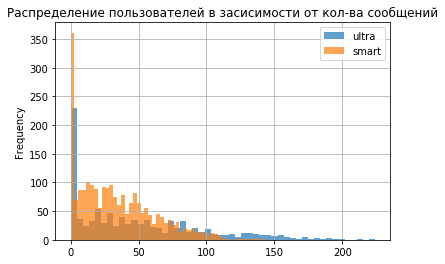

In [90]:
#построим гисторгаммы для 2 тарифов - сообщения

ax=multi[multi['tariff'] == 'ultra'].plot(kind='hist', y='messages', bins=50, alpha=0.7, label='ultra')
multi[multi['tariff'] == 'smart'].plot(kind='hist', y='messages', bins=50, alpha=0.7, label='smart', ax=ax, grid=True, title='Распределение пользователей в засисимости от кол-ва сообщений')

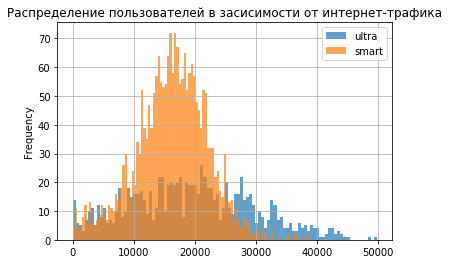

In [91]:
#построим гисторгаммы для 2 тарифов - трафик

ax=multi[multi['tariff'] == 'ultra'].plot(kind='hist', y='mb', bins=100, alpha=0.7, label='ultra')
multi[multi['tariff'] == 'smart'].plot(kind='hist', y='mb', bins=100, alpha=0.7, label='smart', ax=ax, grid=True, title='Распределение пользователей в засисимости от интернет-трафика')

####  Вывод:  
***Телефония:***  
    Пользователи тарифа "Смарт" - среднее значение 417, максимум 500 минут. Самое ТО!   
    Пользователи тарифа "Ультра" - среднее почти в 6 раз меньше максимального значения. Большой запас.
    
    
***Сообщения:***  
      Пользователи обоих тарифов слабо пользуются сообщениями.
    
***Трафик:***  
    Тут только у тарифа "Смарт" среднее значение почти на 1 Гб больше трафика установленного в пакете.
    Пользователи тарифа "Ультра" укладываются в предел значений.  
    
Разброс значений по всем услугам связи у тарифа "Ультра" примерно в 2 раза больше, чем у "Смарт", а дисперсия соответственно примерно в 4.  
    
 

<a id="4"></a>
## Шаг 4. Проверка гипотезы

### Различие средней выручки пользователей тарифов «Ультра» и «Смарт»

In [92]:
#выберем всю выручку по всем абонентам по тарифу Ультра
ultra_money = multi[multi['tariff'] == 'ultra']['total_money'] 
#выберем всю выручку по всем абонентам по тарифу Смарт
smart_money = multi[multi['tariff'] == 'smart']['total_money'] 

In [93]:
#посмотрим выборку по тарифу Ультра
ultra_money.describe()

count     985.000000
mean     2060.529971
std       356.305046
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4743.310547
Name: total_money, dtype: float64

In [94]:
#посмотрим выборку по тарифу Смарт
smart_money.describe()

count    2229.000000
mean     1233.349467
std       787.688141
min       550.000000
25%       550.000000
50%       959.898438
75%      1668.117188
max      6711.015625
Name: total_money, dtype: float64

Гипотеза H₀ будет звучать так "средняя выручка пользователей тарифов «Ультра» и «Смарт» ***не отличаются***, то есть одинаковы!" Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ она звучит как «средняя выручка пользователей тарифов «Ультра» и «Смарт» ***отличаются***».

In [95]:
alpha = .05 # критический уровень статистической значимости (если p-value окажется меньше него - отвергнем гипотезу)

results = st.ttest_ind(
    ultra_money, 
    smart_money,
    equal_var = False) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.931402711366754e-296
Отвергаем нулевую гипотезу


#### Вывод:  
Если мы отвергли нулевую гипотезу, то это означает, что НЕТ правдивости гипотезы "Средняя выручка пользователей тарифов «Ультра» и «Смарт» не отличаются!", то есть не одинаковы! имеет место быть альтернативная гипотеза - отличаются!

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [96]:
#выберем всю выручку по всем абонентам по региону Москва
moscow_money = multi[multi['city'] == 'Москва']['total_money']
#выберем всю выручку по всем абонентам по всем остальным регионам
region_money = multi[multi['city'] != 'Москва']['total_money'] 

In [97]:
moscow_money.describe()

count     611.000000
mean     1507.276762
std       739.758575
min       550.000000
25%       733.394531
50%      1704.632812
75%      1950.000000
max      5186.429688
Name: total_money, dtype: float64

In [98]:
region_money.describe()

count    2603.000000
mean     1482.063727
std       794.042728
min       550.000000
25%       690.234375
50%      1518.078125
75%      1950.000000
max      6711.015625
Name: total_money, dtype: float64

Гипотеза H0 будет звучать так: Cредняя выручка пользователей из Москвы от выручки пользователей из других регионов ***не отличается***, то есть одинаковы выручки! Альтернативная - "Cредняя выручка пользователей из Москвы от выручки пользователей из других регионов ***отличается***, то есть не одинаковы выручки"

In [99]:
alpha = .05 # критический уровень статистической значимости (объем выборки болше 100 - 2176 и 491 соответственно)
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    moscow_money, 
    region_money,
    equal_var = False) #стандартное отклонение отличается

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4549775646471024
Не получилось отвергнуть нулевую гипотезу


#### Вывод:  
Нулевая гипотеза имеет место быть, то есть "средняя выручка пользователей из Москвы от выручки пользователей из других регионов ***не отличаются***, то есть одинаковы!"


<a id="5"></a>
## Шаг 5. Общий вывод

 Что было сделано:  
        Мы открыли все необходимые файлы, исследовали их, обнаружили пропуски и неверные типы данных.  
        Подготовили данные:  
            1. привели всё к нужным типам данных, пропуски решили оставить;  
            2. обнаружили ошибки и исправили их, а именно удалили значения с нулевым потреблением трафика и минут, 
            т.к. данные значения не будут приниматься для дальнейшего анализа;  
            3. сделали сводные таблицы, по которым видно израсходованные кол-во минут, трафик, сообщений по месяцам;  
            4. посчитали выручку с каждого пользователя по месяцам;  
            5. соединили нужные таблицы.
Проанализировали данные:  
            1. Посчитали сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям  
            каждого тарифа в месяц;  
            2. Посчитали среднее количество, дисперсию и стандартное отклонение и построили гистограммы.
        
Какой вывод общий сделан:  

70 % -это пользователи тарифа "Смарт", 30% -"Ультра".  
    Средняя выручка от пользователя тарифа "Ультра" на 40% выше тарифа "Смарт".  
    Большинству пользователей тарифа "Смарт" не хватает бесплатного кол-ва минут и трафика.  
    Пользователи тарифа "Ультра" пользуются минутами экономно и вписываются в свой лимит и даже остается большой запас по всем услугам.  
    Смс- сообщения не популярная услуга для обоих тарифов.  
    Здесь можно посоветовать маркетологам придумать "средний" вариант тарифа- какой-нибудь "Стандарт", чтобы клиенты не платили за доп. услуги и не переплачивали.  
    Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
    